# MOVIELENS RECOMMENDER SYSTEM
Our goal is to build a system that recommends the top 5 movies to a specific user based on their historical ratings. The core idea is to leverage the collective wisdom of all users in the MovieLens dataset to predict what an individual will enjoy. This problem is tackled by answering four fundaments questions:
    
    1. How do we find users with the same movie taste? (Collaborative Filtering (User-User))
    Method: We calculate a "taste similarity" score between users. The most common way is using Cosine Similarity or Pearson Correlation.
    How it works: Each user is represented as a vector of their movies ratings. We then compare the rating vector of our target user to every other user's vector.
    Anology: It's like finding your "movie doppelganger". If you and another user have both rated 20 movies similarly (e.g you both loved the Godfather and hated a particular romantic comedy), the system identifies you as having similar taste. This user's other high-rated movies become strong candidates for your recommendations.
    
    2. How do we find movies that are similar to the ones the user already likes? (Content-Based/item-item Collaborative Filtering)
    Content-Based: We use metadata about the movies like the genres. If a user highly rates Inception, we recommend other movies tagged as "sci-fiction", "thriller".
    Item-Item Collaborative Filtering: Its finds similarity based on user behavior. "People who liked movie X also liked movie Y." We compute similarity between movies based on how users have rated them collectively. For example, if users who rated The Shawshank Redemption highly also consistently rated The Godfather highly, these two movies are deemed similar.
    
    3. How can we predict a user's rating for an unrated movie?
    This is the core prediction engine, by combining the concepts above.
    User-User Prediction: To predict your rating for Movie M, the system looks at the users most similar to you (your "neighbors") who have already rated Movie M. Your predicted rating is a weighted average of their ratings for that movie.
    Item-Item Prediction: To predict your rating for Movie M, the system looks at the movies most similarr to Movie M that you have already rated. Your predicted rating is calculated based on your ratings for these similar movies.
    
    4. How do we generate the final Top 5 recommendations?
    Once we can predict ratings, then we:
    Generate Predictions: For our target user, we run the predictions algorithm for all movies they have not yet seen.
    Rank the list: We sort this list of unseen movies by their predicted rating in descending order.
    Select the top N: The top 5 movies from this sorted list are selected as the final recommendations.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds


import warnings
warnings.filterwarnings('ignore')

# Set styling for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

%matplotlib inline

In [3]:
# Display the first few rows of each to get a initial feel
print("MOVIES DATA:")
print(df_movies.head())
print("\n" + "="*50 + "\n")

print("RATINGS DATA:")
print(df_ratings.head())
print("\n" + "="*50 + "\n")

print("TAGS DATA:")
print(df_tags.head())
print("\n" + "="*50 + "\n")

print("LINKS DATA:")
print(df_links.head())

MOVIES DATA:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


RATINGS DATA:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


TAGS DATA:
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  14

In [4]:
def basic_info(df, name):
    """Prints basic information about a DataFrame."""
    print(f"--- {name} INFO ---")
    print(f"Shape: {df.shape}")  # (rows, columns)
    print("\nData Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\n" + "-"*40)

# Apply to all DataFrames
basic_info(df_movies, "MOVIES")
basic_info(df_ratings, "RATINGS")
basic_info(df_tags, "TAGS")
basic_info(df_links, "LINKS")

--- MOVIES INFO ---
Shape: (9742, 3)

Data Types:
movieId     int64
title      object
genres     object
dtype: object

Missing Values:
movieId    0
title      0
genres     0
dtype: int64

----------------------------------------
--- RATINGS INFO ---
Shape: (100836, 4)

Data Types:
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

Missing Values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

----------------------------------------
--- TAGS INFO ---
Shape: (3683, 4)

Data Types:
userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object

Missing Values:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

----------------------------------------
--- LINKS INFO ---
Shape: (9742, 3)

Data Types:
movieId      int64
imdbId       int64
tmdbId     float64
dtype: object

Missing Values:
movieId    0
imdbId     0
tmdbId     8
dtype: int64

------------------------

In [5]:
# Display settings for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set a professional color palette and style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
professional_palette = ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D", "#3B1F2B", "#6A8EAE"]
sns.set_palette(professional_palette)

# Custom style parameters
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 14

--- MOVIES DEEP DIVE ---
Total number of movies: 9742

Sample of movie titles:
['Turkish Delight (Turks fruit) (1973)', 'Blues Brothers, The (1980)', 'I Am a Fugitive from a Chain Gang (1932)', 'Abominable Dr. Phibes, The (1971)', 'Oklahoma! (1955)', "Ulee's Gold (1997)", "Brain That Wouldn't Die, The (1962)", 'Mumford (1999)', "Alice Doesn't Live Here Anymore (1974)", 'High Art (1998)']

Year range: 1902 - 2018
Movies without year: 13

--- GENRE ANALYSIS ---
Total genre occurrences: 22084
Unique genres: ['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'War' 'Musical'
 'Documentary' 'IMAX' 'Western' 'Film-Noir' '(no genres listed)']


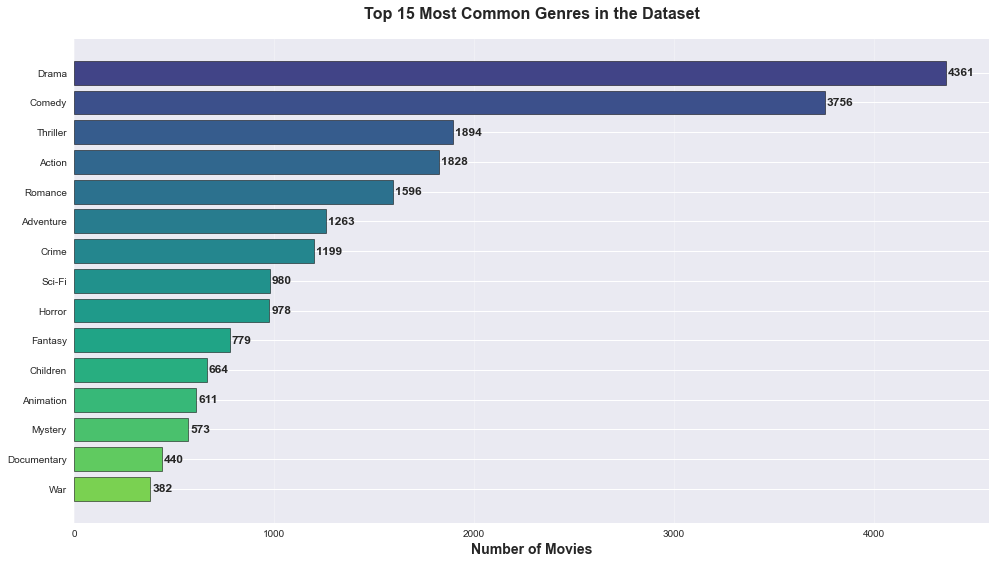

In [6]:
print("--- MOVIES DEEP DIVE ---")
print(f"Total number of movies: {df_movies['movieId'].nunique()}")
print("\nSample of movie titles:")
print(df_movies['title'].sample(10).tolist())

# Let's extract the year from the title and see the range
# Note: This is a common pattern in Movielens data: "Title (Year)"
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)')
df_movies['year'] = pd.to_numeric(df_movies['year'], errors='coerce').astype('Int64')

print(f"\nYear range: {df_movies['year'].min()} - {df_movies['year'].max()}")
print(f"Movies without year: {df_movies['year'].isnull().sum()}")

# Analyze genres
print("\n--- GENRE ANALYSIS ---")
# Split genres which are pipe-separated
all_genres = df_movies['genres'].str.split('|', expand=True).stack()
print(f"Total genre occurrences: {len(all_genres)}")
print(f"Unique genres: {all_genres.unique()}")

# Top genres
plt.figure(figsize=(14, 8))
genre_counts = all_genres.value_counts().head(15)

# Create a gradient color palette based on count values
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(genre_counts)))
bars = plt.barh(range(len(genre_counts)), genre_counts.values, color=colors, edgecolor='black', linewidth=0.5)

plt.yticks(range(len(genre_counts)), genre_counts.index)
plt.xlabel('Number of Movies', fontweight='bold')
plt.title('Top 15 Most Common Genres in the Dataset', fontweight='bold', pad=20)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 10, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
             ha='left', va='center', fontweight='bold')

plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

--- RATINGS DEEP DIVE ---


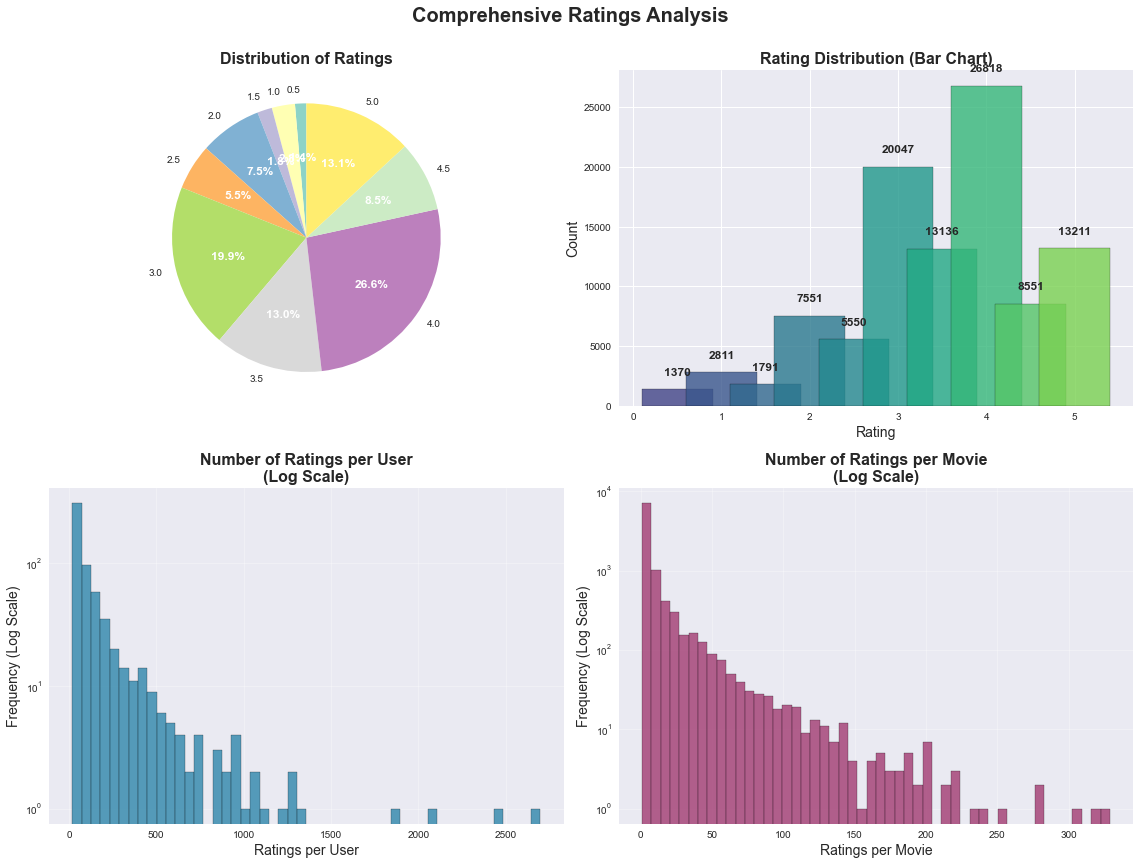

Rating period: 1996-03-29 18:36:55 to 2018-09-24 14:27:30


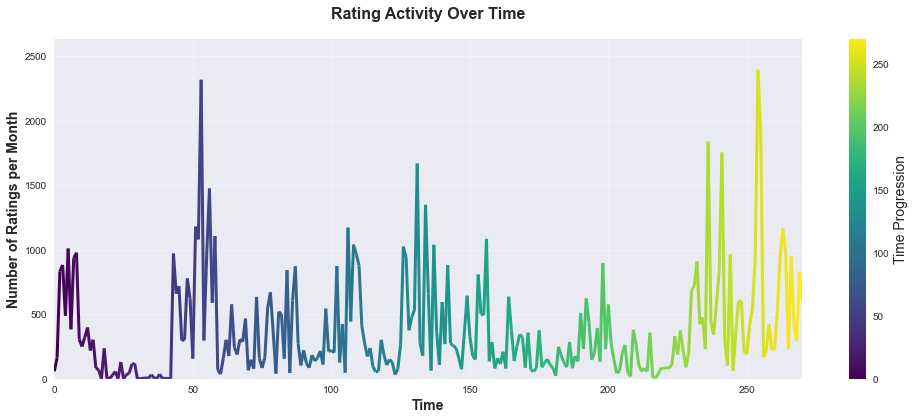

In [7]:
print("--- RATINGS DEEP DIVE ---")

# Create a comprehensive ratings overview plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comprehensive Ratings Analysis', fontsize=20, fontweight='bold', y=1.0)

# 1. Rating distribution (pie chart)
rating_counts = df_ratings['rating'].value_counts().sort_index()
colors_ratings = plt.cm.Set3(np.linspace(0, 1, len(rating_counts)))
wedges, texts, autotexts = axes[0,0].pie(rating_counts.values, labels=rating_counts.index, 
                                        colors=colors_ratings, autopct='%1.1f%%', startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
axes[0,0].set_title('Distribution of Ratings', fontweight='bold')

# 2. Rating distribution (bar chart)
colors_bars = plt.cm.viridis(np.linspace(0.2, 0.8, len(rating_counts)))
axes[0,1].bar(rating_counts.index, rating_counts.values, color=colors_bars, 
              edgecolor='black', alpha=0.8)
axes[0,1].set_xlabel('Rating')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Rating Distribution (Bar Chart)', fontweight='bold')
for i, v in enumerate(rating_counts.values):
    axes[0,1].text(rating_counts.index[i], v + 1000, str(v), 
                   ha='center', va='bottom', fontweight='bold')

# 3. Ratings per user (with log scale for better visualization)
user_rating_counts = df_ratings['userId'].value_counts()
axes[1,0].hist(user_rating_counts, bins=50, color='#2E86AB', edgecolor='black', alpha=0.8)
axes[1,0].set_yscale('log')
axes[1,0].set_xlabel('Ratings per User')
axes[1,0].set_ylabel('Frequency (Log Scale)')
axes[1,0].set_title('Number of Ratings per User\n(Log Scale)', fontweight='bold')
axes[1,0].grid(alpha=0.3)

# 4. Ratings per movie (with log scale)
movie_rating_counts = df_ratings['movieId'].value_counts()
axes[1,1].hist(movie_rating_counts, bins=50, color='#A23B72', edgecolor='black', alpha=0.8)
axes[1,1].set_yscale('log')
axes[1,1].set_xlabel('Ratings per Movie')
axes[1,1].set_ylabel('Frequency (Log Scale)')
axes[1,1].set_title('Number of Ratings per Movie\n(Log Scale)', fontweight='bold')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Temporal analysis with enhanced styling
df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
print(f"Rating period: {df_ratings['timestamp'].min()} to {df_ratings['timestamp'].max()}")

plt.figure(figsize=(14, 6))
monthly_ratings = df_ratings.set_index('timestamp').resample('M').size()

# Create a gradient line plot
x = range(len(monthly_ratings))
y = monthly_ratings.values

# Create a gradient colored line
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

from matplotlib.collections import LineCollection
lc = LineCollection(segments, cmap='viridis', linewidth=3)
lc.set_array(np.array(x))

plt.gca().add_collection(lc)
plt.xlim(min(x), max(x))
plt.ylim(0, max(y) * 1.1)

plt.xlabel('Time', fontweight='bold')
plt.ylabel('Number of Ratings per Month', fontweight='bold')
plt.title('Rating Activity Over Time', fontweight='bold', pad=20)


# Add a colorbar
plt.colorbar(lc, label='Time Progression')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

--- TAGS ANALYSIS ---


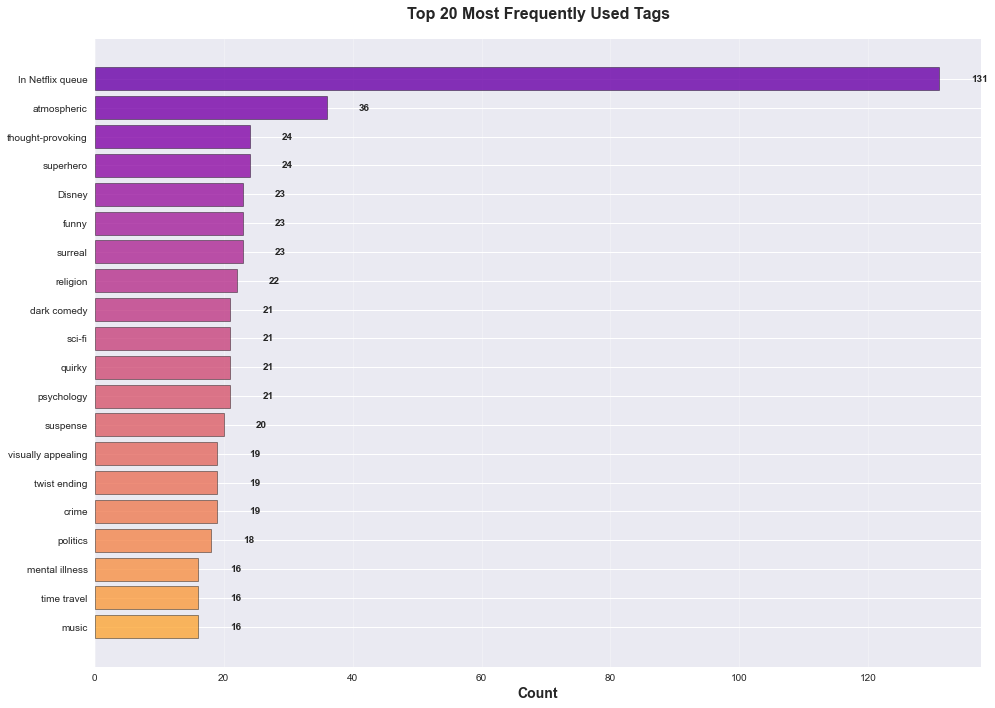

In [8]:
print("--- TAGS ANALYSIS ---")

# Most common tags with beautiful horizontal bar chart
plt.figure(figsize=(14, 10))
top_tags = df_tags['tag'].value_counts().head(20)

# Create a colorful gradient
colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(top_tags)))
bars = plt.barh(range(len(top_tags)), top_tags.values, color=colors, 
                edgecolor='black', linewidth=0.5, alpha=0.8)

plt.yticks(range(len(top_tags)), top_tags.index)
plt.xlabel('Count', fontweight='bold')
plt.title('Top 20 Most Frequently Used Tags', fontweight='bold', pad=20)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
             ha='left', va='center', fontweight='bold', fontsize=10)

plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# Merge ratings with movie information
df_ratings_movies = pd.merge(df_ratings, df_movies, on='movieId')
print("Ratings merged with movie info:")
print(df_ratings_movies.head())

# Average rating per movie
movie_stats = df_ratings_movies.groupby('movieId').agg({
    'rating': ['count', 'mean'],
    'title': 'first'
}).round(2)
movie_stats.columns = ['rating_count', 'avg_rating', 'title']
movie_stats = movie_stats.reset_index()

print("\nMovies with highest number of ratings:")
print(movie_stats.nlargest(10, 'rating_count')[['title', 'rating_count', 'avg_rating']])

print("\nMovies with highest average rating (min 50 ratings):")
high_rated = movie_stats[movie_stats['rating_count'] >= 50]
print(high_rated.nlargest(10, 'avg_rating')[['title', 'rating_count', 'avg_rating']])

Ratings merged with movie info:
   userId  movieId  rating           timestamp             title  \
0       1        1     4.0 2000-07-30 18:45:03  Toy Story (1995)   
1       5        1     4.0 1996-11-08 06:36:02  Toy Story (1995)   
2       7        1     4.5 2005-01-25 06:52:26  Toy Story (1995)   
3      15        1     2.5 2017-11-13 12:59:30  Toy Story (1995)   
4      17        1     4.5 2011-05-18 05:28:03  Toy Story (1995)   

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1  Adventure|Animation|Children|Comedy|Fantasy  1995  
2  Adventure|Animation|Children|Comedy|Fantasy  1995  
3  Adventure|Animation|Children|Comedy|Fantasy  1995  
4  Adventure|Animation|Children|Comedy|Fantasy  1995  

Movies with highest number of ratings:
                                          title  rating_count  avg_rating
314                         Forrest Gump (1994)           329        4.16
277            Shawshank Redemption, The 

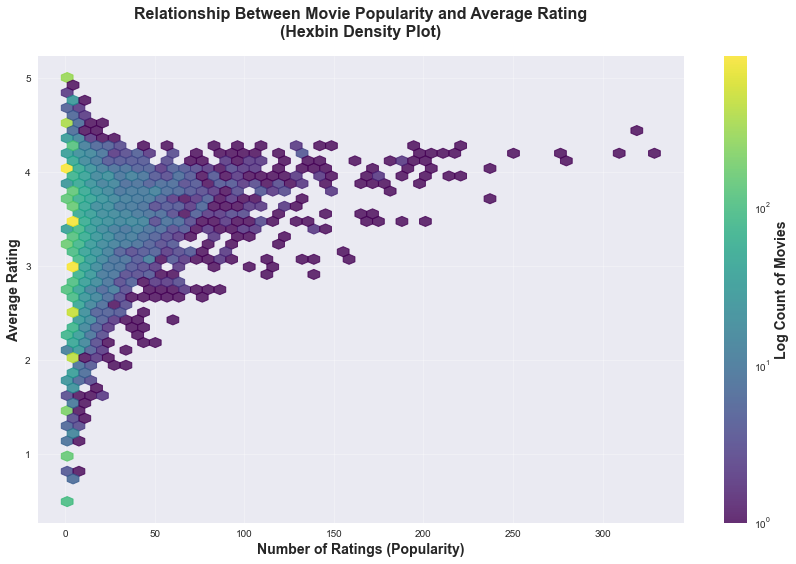

In [10]:
# Relationship between popularity and rating 
plt.figure(figsize=(12, 8))

# Create a hexbin plot for better density visualization
hb = plt.hexbin(movie_stats['rating_count'], movie_stats['avg_rating'], 
                gridsize=50, cmap='viridis', bins='log', alpha=0.8)

plt.xlabel('Number of Ratings (Popularity)', fontweight='bold')
plt.ylabel('Average Rating', fontweight='bold')
plt.title('Relationship Between Movie Popularity and Average Rating\n(Hexbin Density Plot)', 
          fontweight='bold', pad=20)

# Add colorbar
cb = plt.colorbar(hb, label='Log Count of Movies')
cb.set_label('Log Count of Movies', fontweight='bold')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


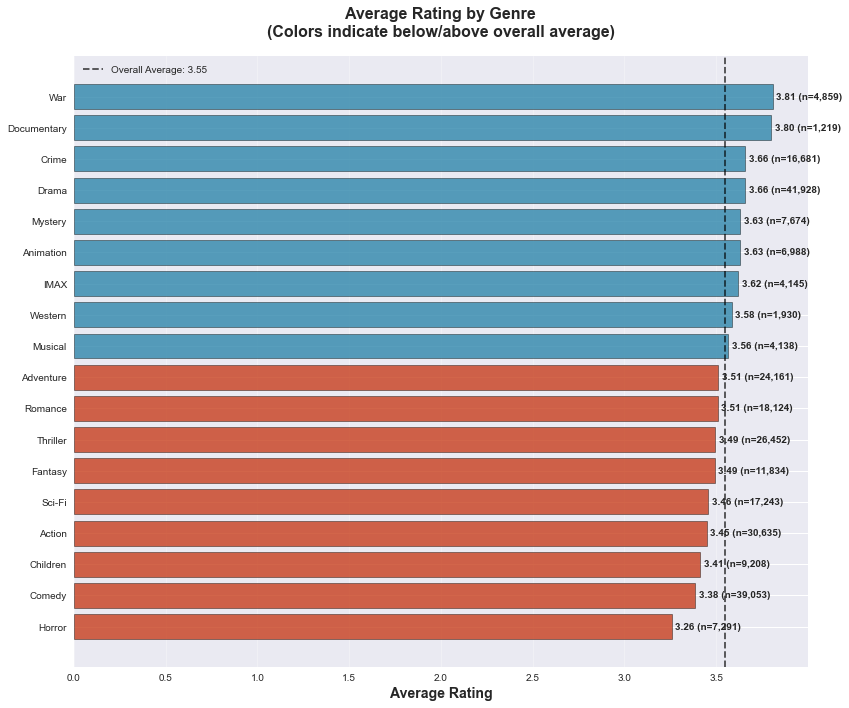

In [11]:
# Average rating by genre
genre_ratings = df_ratings_movies.copy()
# Expand genres so we can analyze them separately
genre_ratings['genres'] = genre_ratings['genres'].str.split('|')
genre_ratings = genre_ratings.explode('genres')

genre_avg = genre_ratings.groupby('genres')['rating'].agg(['mean', 'count']).round(3)
genre_avg = genre_avg[genre_avg['count'] > 1000]  # Filter for meaningful genres
genre_avg = genre_avg.sort_values('mean', ascending=False)

plt.figure(figsize=(12, 10))
genre_avg = genre_avg.sort_values('mean', ascending=True)  # Sort for horizontal bar chart

# Create a diverging color palette based on rating values
colors = ['#C73E1D' if x < genre_avg['mean'].mean() else '#2E86AB' for x in genre_avg['mean']]

bars = plt.barh(range(len(genre_avg)), genre_avg['mean'], color=colors, 
                edgecolor='black', linewidth=0.5, alpha=0.8)

plt.yticks(range(len(genre_avg)), genre_avg.index)
plt.xlabel('Average Rating', fontweight='bold')
plt.title('Average Rating by Genre\n(Colors indicate below/above overall average)', 
          fontweight='bold', pad=20)

# Add rating values and count information
for i, bar in enumerate(bars):
    width = bar.get_width()
    count = genre_avg['count'].iloc[i]
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f} (n={count:,})', 
             ha='left', va='center', fontweight='bold', fontsize=10)

# Add average line
plt.axvline(x=genre_avg['mean'].mean(), color='black', linestyle='--', alpha=0.7, 
            label=f'Overall Average: {genre_avg["mean"].mean():.2f}')
plt.legend()

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# BASELINE MODEL

In [12]:
# 1. Check data sparsity
n_users = df_ratings['userId'].nunique()
n_movies = df_movies['movieId'].nunique()
n_ratings = len(df_ratings)
sparsity = (1 - (n_ratings / (n_users * n_movies))) * 100

print(f"Users: {n_users:,}")
print(f"Movies: {n_movies:,}")
print(f"Ratings: {n_ratings:,}")
print(f"Matrix Sparsity: {sparsity:.4f}%")
print()

Users: 610
Movies: 9,742
Ratings: 100,836
Matrix Sparsity: 98.3032%



In [13]:
# 2. Filter for meaningful data (remove users/movies with too few ratings)
# This helps with computational efficiency and reduces noise
MIN_RATINGS_PER_USER = 10
MIN_RATINGS_PER_MOVIE = 5

print("Filtering sparse data...")
user_counts = df_ratings['userId'].value_counts()
movie_counts = df_ratings['movieId'].value_counts()

df_ratings_filtered = df_ratings[
    df_ratings['userId'].isin(user_counts[user_counts >= MIN_RATINGS_PER_USER].index) &
    df_ratings['movieId'].isin(movie_counts[movie_counts >= MIN_RATINGS_PER_MOVIE].index)
]

print(f"After filtering: {len(df_ratings_filtered):,} ratings "
      f"({len(df_ratings_filtered)/len(df_ratings)*100:.1f}% of original)")

Filtering sparse data...
After filtering: 90,274 ratings (89.5% of original)


In [14]:
df_ratings_filtered.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [15]:
# 3. Train-Test Split (Time-based split to simulate real-world scenario)
print("\nPerforming time-based train-test split...")
df_ratings_filtered['timestamp'] = pd.to_datetime(df_ratings_filtered['timestamp'], unit='s')
df_ratings_filtered = df_ratings_filtered.sort_values('timestamp')

# Use last 20% of each user's ratings as test set, 80% training 
train_data = []
test_data = []

for user_id in df_ratings_filtered['userId'].unique():
    user_ratings = df_ratings_filtered[df_ratings_filtered['userId'] == user_id]
    split_idx = int(0.8 * len(user_ratings))
    
    train_data.append(user_ratings.iloc[:split_idx])
    test_data.append(user_ratings.iloc[split_idx:])

df_train = pd.concat(train_data)
df_test = pd.concat(test_data)

print(f"Training set: {len(df_train):,} ratings ({len(df_train)/len(df_ratings_filtered)*100:.1f}%)")
print(f"Test set: {len(df_test):,} ratings ({len(df_test)/len(df_ratings_filtered)*100:.1f}%)")
print(f"Train users: {df_train['userId'].nunique()}")
print(f"Test users: {df_test['userId'].nunique()}")


Performing time-based train-test split...
Training set: 71,971 ratings (79.7%)
Test set: 18,303 ratings (20.3%)
Train users: 610
Test users: 610


In [16]:
print("\n" + "="*60)
print("BASELINE MODEL 1: GLOBAL MEAN + USER BIAS + MOVIE BIAS")
print("="*60)

class SimpleCollaborativeFiltering:
    """Simple baseline model using mean-centered collaborative filtering."""
    
    def __init__(self):
        self.global_mean = None
        self.user_biases = {}
        self.movie_biases = {}
        
    def fit(self, train_data):
        """Train the model on training data."""
        # 1. Calculate global mean
        self.global_mean = train_data['rating'].mean()
        
        # 2. Calculate user biases (how much each user deviates from global mean)
        user_means = train_data.groupby('userId')['rating'].mean()
        self.user_biases = (user_means - self.global_mean).to_dict()
        
        # 3. Calculate movie biases (how much each movie deviates from user-adjusted mean)
        # First adjust ratings by user bias
        train_data['user_adjusted'] = train_data.apply(
            lambda row: row['rating'] - self.user_biases.get(row['userId'], 0), 
            axis=1
        )
        
        movie_means = train_data.groupby('movieId')['user_adjusted'].mean()
        self.movie_biases = (movie_means - self.global_mean).to_dict()
        
        print(f"Global mean rating: {self.global_mean:.3f}")
        print(f"Number of user biases calculated: {len(self.user_biases)}")
        print(f"Number of movie biases calculated: {len(self.movie_biases)}")
        
        return self
    
    def predict(self, user_id, movie_id):
        """Predict rating for a user-movie pair."""
        if user_id not in self.user_biases or movie_id not in self.movie_biases:
            # Handle cold start: return global mean
            return self.global_mean
        
        prediction = self.global_mean + self.user_biases[user_id] + self.movie_biases[movie_id]
        
        # Clip to rating range [0.5, 5.0]
        return np.clip(prediction, 0.5, 5.0)
    
    def recommend(self, user_id, k=5, movie_pool=None):
        """Generate top-k recommendations for a user."""
        if movie_pool is None:
            # Use all movies in training data
            movie_pool = list(self.movie_biases.keys())
        
        predictions = []
        for movie_id in movie_pool:
            pred_rating = self.predict(user_id, movie_id)
            predictions.append((movie_id, pred_rating))
        
        # Sort by predicted rating (descending) and return top k
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:k]

# Train the baseline model
print("\nTraining baseline model...")
baseline_model = SimpleCollaborativeFiltering()
baseline_model.fit(df_train)


BASELINE MODEL 1: GLOBAL MEAN + USER BIAS + MOVIE BIAS

Training baseline model...
Global mean rating: 3.548
Number of user biases calculated: 610
Number of movie biases calculated: 3648


In [17]:
print("\n" + "="*60)
print("BASELINE MODEL EVALUATION")
print("="*60)

# 1. Evaluate on test set
def evaluate_model(model, test_df):
    """Evaluate model predictions on test set."""
    predictions = []
    actuals = []
    
    for _, row in test_df.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        actual_rating = row['rating']
        
        pred_rating = model.predict(user_id, movie_id)
        predictions.append(pred_rating)
        actuals.append(actual_rating)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = np.mean(np.abs(np.array(actuals) - np.array(predictions)))
    
    return rmse, mae, predictions, actuals

# Evaluate baseline model
rmse_baseline, mae_baseline, preds, actuals = evaluate_model(baseline_model, df_test)
print(f"Test Set RMSE: {rmse_baseline:.4f}")
print(f"Test Set MAE: {mae_baseline:.4f}")

# 2. Check coverage (how many test cases we can predict)
test_coverage = len([1 for _, row in df_test.iterrows() 
                     if (row['userId'] in baseline_model.user_biases and 
                         row['movieId'] in baseline_model.movie_biases)])
coverage_pct = test_coverage / len(df_test) * 100
print(f"Prediction Coverage: {coverage_pct:.2f}%")

# 3. Compare with naive/basic/general baselines
naive_global_mean = np.full(len(df_test), df_train['rating'].mean())
rmse_naive = np.sqrt(mean_squared_error(df_test['rating'], naive_global_mean))

user_means = df_train.groupby('userId')['rating'].mean()
movie_means = df_train.groupby('movieId')['rating'].mean()

# User mean baseline
user_mean_preds = df_test['userId'].map(user_means).fillna(df_train['rating'].mean())
rmse_user_mean = np.sqrt(mean_squared_error(df_test['rating'], user_mean_preds))

# Movie mean baseline
movie_mean_preds = df_test['movieId'].map(movie_means).fillna(df_train['rating'].mean())
rmse_movie_mean = np.sqrt(mean_squared_error(df_test['rating'], movie_mean_preds))

print("\nComparison with Naive Baselines:")
print(f"  - Global Mean Only:        RMSE = {rmse_naive:.4f}")
print(f"  - User Mean (with fill):   RMSE = {rmse_user_mean:.4f}")
print(f"  - Movie Mean (with fill):  RMSE = {rmse_movie_mean:.4f}")
print(f"  - Our Baseline Model:      RMSE = {rmse_baseline:.4f}")
print(f"    Improvement over Global Mean: {(rmse_naive - rmse_baseline)/rmse_naive*100:.1f}%")

# 4. Generate sample recommendations
print("\n" + "="*60)
print("SAMPLE RECOMMENDATIONS")
print("="*60)

# Get a random user from test set
sample_user = df_test['userId'].iloc[0]
print(f"Sample recommendations for User {sample_user}:")

# Movies this user has already rated (for context)
user_rated = df_train[df_train['userId'] == sample_user]
if len(user_rated) > 0:
    print(f"\nUser's top rated movies:")
    top_rated = user_rated.nlargest(3, 'rating')
    for _, row in top_rated.iterrows():
        movie_title = df_movies[df_movies['movieId'] == row['movieId']]['title'].iloc[0]
        print(f"  - {movie_title}: {row['rating']} stars")

# Generate recommendations
recommendations = baseline_model.recommend(sample_user, k=5)
print(f"\nTop 5 Recommended Movies:")

for i, (movie_id, pred_rating) in enumerate(recommendations, 1):
    movie_title = df_movies[df_movies['movieId'] == movie_id]['title'].iloc[0]
    print(f"  {i}. {movie_title} (Predicted: {pred_rating:.2f} stars)")


BASELINE MODEL EVALUATION
Test Set RMSE: 0.9059
Test Set MAE: 0.6913
Prediction Coverage: 99.95%

Comparison with Naive Baselines:
  - Global Mean Only:        RMSE = 1.0464
  - User Mean (with fill):   RMSE = 0.9578
  - Movie Mean (with fill):  RMSE = 0.9811
  - Our Baseline Model:      RMSE = 0.9059
    Improvement over Global Mean: 13.4%

SAMPLE RECOMMENDATIONS
Sample recommendations for User 429:

User's top rated movies:
  - Crimson Tide (1995): 5.0 stars
  - Apollo 13 (1995): 5.0 stars
  - Aladdin (1992): 5.0 stars

Top 5 Recommended Movies:
  1. Paths of Glory (1957) (Predicted: 5.00 stars)
  2. Jules and Jim (Jules et Jim) (1961) (Predicted: 5.00 stars)
  3. Yojimbo (1961) (Predicted: 5.00 stars)
  4. Mr. Death: The Rise and Fall of Fred A. Leuchter, Jr. (1999) (Predicted: 5.00 stars)
  5. Five Easy Pieces (1970) (Predicted: 5.00 stars)


In [18]:
## testing on unkown user_id 
recommendations = baseline_model.recommend(710, k=5)
print(f"\nTop 5 Recommended Movies:")

for i, (movie_id, pred_rating) in enumerate(recommendations, 1):
    movie_title = df_movies[df_movies['movieId'] == movie_id]['title'].iloc[0]
    print(f"  {i}. {movie_title} (Predicted: {pred_rating:.2f} stars)")


Top 5 Recommended Movies:
  1. Toy Story (1995) (Predicted: 3.55 stars)
  2. Jumanji (1995) (Predicted: 3.55 stars)
  3. Grumpier Old Men (1995) (Predicted: 3.55 stars)
  4. Waiting to Exhale (1995) (Predicted: 3.55 stars)
  5. Father of the Bride Part II (1995) (Predicted: 3.55 stars)
